In [9]:
# !pip install qiskit-nature

In [1]:
from math import pi
import json
from pathlib import Path

import numpy as np
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz

In [2]:
class BiGraphNode(dict):
    def __new__(cls, *args, **kwargs):
        instance = super().__new__(cls)
        return instance
        
    def __init__(self, *args, name=None, node_id=None, **kwargs):
        # Initialize the parent class
        super().__init__(*args, **kwargs)
        self.name = name or list(self.keys())[0]
        self.node_id = node_id


from dataclasses import dataclass

@dataclass
class BiGraphEdge:
    node_a: BiGraphNode
    node_b: BiGraphNode
    weight: float | complex
    

class BiGraph:
    nodes: list[BiGraphNode]
    edges: list[BiGraphEdge]
    graph: rx.PyGraph
    u: float
    
    def __init__(self, bigraph_filepath: str, u: float = 5.0, weighted_edges: list[tuple] = None):
        self.u = u
        self.bigraph_nodes = self.get_bigraph_nodes(bigraph_filepath)
        self.node_names = [node.name for node in self.bigraph_nodes]
        
        self.graph = self.construct_graph()

        # add nodes
        for i, node in enumerate(self.bigraph_nodes):
            self.add_node(node.name)
            node.node_id = i

        # add edges if passed
        if weighted_edges is not None:
            for edge in weighted_edges:
                self.add_edge(*edge)
                
    def get_bigraph_nodes(self, bigraph_filepath: str) -> list[BiGraphNode]:
        fp = bigraph_filepath
        with open(fp, 'r') as f:
            bigraph = json.load(f)
            
        # get n nodes from bigraph doc
        bigraph_state = bigraph['state']
        node_data = [k for k, v in bigraph_state.items() if "global_time" not in k and "emitter" not in k]
        nodes = [
            BiGraphNode({node_name: [item for item in node_data if "store" in item and node_name in item]})
            for node_name in node_data if "store" not in node_name
        ]
        
        return nodes
        
    def construct_graph(self) -> rx.PyGraph:
        return rx.PyGraph(multigraph=False)

    def add_node(self, node_name: str) -> None:
        if node_name not in self.graph.nodes():
            self.graph.add_node(node_name)
            print(f"Added a Node to the graph: {node_name}")

    def add_edge(self, node_a_name: str, node_b_name: str, weight: float | complex):
        edge = []
        edges = []
        for node in self.bigraph_nodes:
            if node.name == node_a_name or node.name == node_b_name:
                edge.append(node.node_id)
        edge.append(weight)
        
        edges.append(tuple(edge))
        self.graph.add_edges_from([tuple(edge)])
        print(f"Added an Edge to the bigraph: {edge}")

    def lattice(self) -> Lattice:
        return Lattice(self.graph)

    def generate_fhm(self):
        return FermiHubbardModel(
            lattice=self.lattice(),
            onsite_interaction=self.u
        )

    def generate_problem(self):
        fhm = self.generate_fhm()
        return LatticeModelProblem(fhm)

    def get_ground_state(self) -> float:
        # generate problem
        lmp = self.generate_problem()

        # define mappers
        numpy_solver = NumPyMinimumEigensolver()
        qubit_mapper = JordanWignerMapper()

        # calc and solve ground state
        calc = GroundStateEigensolver(qubit_mapper, numpy_solver)
        res = calc.solve(lmp)
        print(res)
        return res
        

bigraph_fp = "/Users/alexanderpatrie/Desktop/repos/bio-compose-server/tests/test_output/time-course-update.json"
weighted_edges = [
    ("copasi", "pysces", 1.0 + 1.0j),
    ("copasi", "tellurium", 1.0 + 1.0j),
    ("pysces", "tellurium", 1.0 + 3.0j)
]

In [3]:
bigraph = BiGraph(bigraph_fp, 5.0, weighted_edges)

Added a Node to the graph: copasi
Added a Node to the graph: pysces
Added a Node to the graph: tellurium
Added an Edge to the bigraph: [0, 1, (1+1j)]
Added an Edge to the bigraph: [0, 2, (1+1j)]
Added an Edge to the bigraph: [1, 2, (1+3j)]


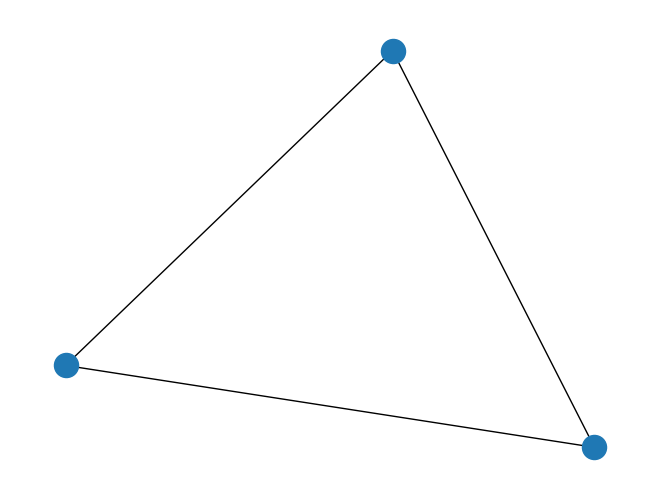

In [4]:
general_lattice = bigraph.lattice()
general_lattice.draw()

In [5]:
gs = bigraph.get_ground_state()

=== GROUND STATE ===
 
* Lattice ground state energy : -5.69251184116


In [14]:
from process_bigraph import Process, Step


class VariableReduction(Process):
    """Run reduce_variables() workflow here"""
    pass


class VariableChecker(Step):
    """takes N as input state and checks if N == Ncrit"""
    pass


from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


class Grover(Process):
    config_schema = {}

    def __init__(self, config, core):
        super().__init__(config, core)


class RQAOA(Process):
    config_schema = {
        'n_nodes': 'integer',
        'edge_list': 'list',
    }

    def __init__(self, config, core):
        super().__init__(config, core)
        self.n_nodes = self.config.get('n_nodes')
        self.graph = rx.PyGraph()

        # add nodes
        self.graph.add_nodes_from(
            np.arange(0, self.n_nodes, 1)
        )

        # add edges from parameters
        self.graph.add_edges_from(
            self.config.get('edge_list')
        )
        self.max_cut_paulis = build_max_cut_paulis(self.graph)
        self.H_cost = SparsePauliOp.from_list(self.max_cut_paulis)
        self.circuit = QAOAAnsatz(cost_operator=self.H_cost, reps=2)
        self.measure()

    def measure(self):
        return self.circuit.measure_all()



class MolecularQAOA(Process):
    config_schema = {
        'nuclei': 'list[list[float]]'
    }

    def __init__(self, config, core):
        super().__init__(config, core)

        # position vectors of all nuclei involved in solving
        self.R = self.config['nuclei']

In [11]:
from bio_bundles import registrar
CORE = registrar.core

rqaoa = RQAOA(
    config={
        'n_nodes': 5,
        'edge_list': [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)] 
    },
    core=CORE
)

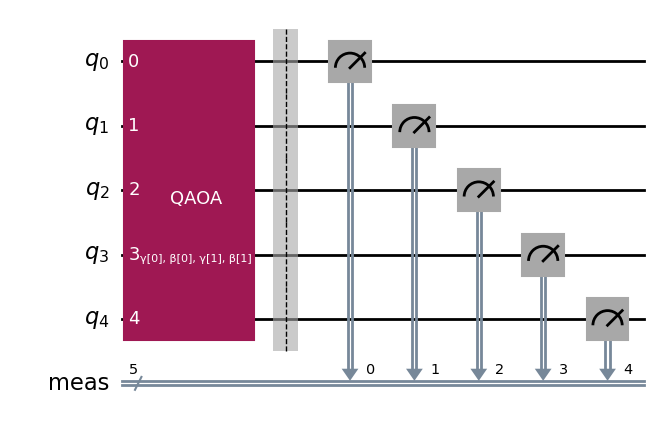

In [12]:
rqaoa.circuit.draw('mpl')

In [13]:
"""R is an array of arrays of shape: (n, 3)
    where n is the number of nuclei involved in the hamiltonian, and 
    3 represent position vector dimesions (x, y, z) for each n
"""

'R is an array of arrays of shape: (n, 3)\n    where n is the number of nuclei involved in the hamiltonian, and \n    3 represent position vector dimesions (x, y, z) for each n\n'

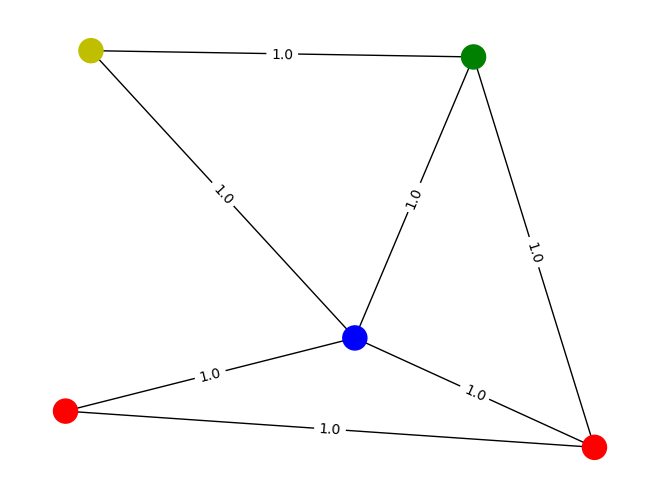

In [26]:
import numpy as np
import networkx as nx

num_nodes = 5
w = np.array(
    [[0.0, 1.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0]]
)
G = nx.from_numpy_array(w)

layout = nx.random_layout(G, seed=10)
colors = ["r", "g", "b", "y", "r"]
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [27]:
def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)


def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part


# use the brute-force way to generate the oracle
L = num_nodes
max = 2**L
sol = np.inf
for i in range(max):
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur)
    if how_many_nonzero * 2 != L:  # not balanced
        continue

    cur_v = objective_value(np.array(cur), w)
    if cur_v < sol:
        sol = cur_v

print(f"Objective value computed by the brute-force method is {sol}")

Objective value computed by the brute-force method is inf


In [28]:
from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


qubit_op, offset = get_operator(w)

In [29]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

sampler = Sampler()


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)


algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {objective_value(x, w)}")


[0 0 1 1 1]
Objective value computed by QAOA is 4


/var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/ipykernel_5013/2309099178.py:10: DeprecationWarning:

The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.



In [30]:
from qiskit.circuit.library import TwoLocal

from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
ansatz = TwoLocal(qubit_op.num_qubits, "ry", "cz", reps=2, entanglement="linear")
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer)

result = sampling_vqe.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by SamplingVQE is {objective_value(x, w)}")


[1 0 1 0 1]
Objective value computed by SamplingVQE is 3


In [153]:
from dotenv import load_dotenv

load_dotenv("../.env")

True

In [148]:
from bio_bundles import registrar
from math import sqrt
from typing import *
from qiskit.circuit.library import QAOAAnsatz


def get_node_pairs(nodes: list):
    from itertools import combinations
    return list(combinations(nodes, 2))


def random_weight():
    n = np.random.rand()
    return n**n/n if n > 0.5 else n**n*n


def get_weights(node_pairs: list[tuple], generator: Callable):
    # node_list = [(0, 1), (0, 2), (0, 4), (1, 2), (2, 3), (3, 4)]
    return list(map(
        lambda nodes: (*nodes, generator()),
        node_pairs
    ))


def draw_graph(process: QAOAProcess, node_size=600):
    from rustworkx.visualization import mpl_draw as _draw_graph
    return _draw_graph(process.graph, node_size=node_size, with_labels=True)


def configure_runtime(circuit: QAOAAnsatz):
    import os
    from qiskit_ibm_runtime import QiskitRuntimeService
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    
    QiskitRuntimeService.save_account(channel="ibm_quantum", token=os.getenv("IBM_QUANTUM_TOKEN"), overwrite=True, set_as_default=True)
    service = QiskitRuntimeService(channel='ibm_quantum')
    backend = service.least_busy(min_num_qubits=127)
    print(backend)
    
    # Create pass manager for transpilation
    pm = generate_preset_pass_manager(optimization_level=3,
                                        backend=backend)
    
    candidate_circuit = pm.run(circuit)
    candidate_circuit.draw('mpl', fold=False, idle_wires=False)
    
    return backend, pm, candidate_circuit


class GroverProcess(Process):
    config_schema = {
        "target": "string"
    }

    def __init__(self, config, core):
        super().__init__(config, core)


class QAOAProcess(Process):
    config_schema = {
        "n_variables": "integer",
        "edge_list": "list[tuple[float]]",  # in the format: [(node_a, node_b, weight/is_connected(1 or 0)), ...]
    }

    def __init__(self, config, core):
        super().__init__(config, core)
        self.graph = rx.PyGraph()
        self.n_variables = self.config["n_variables"]

        # initial params for probablistic terms
        self.initial_gamma = np.pi
        self.initial_beta = np.pi/2
        self.init_params = [self.initial_gamma, self.initial_beta, self.initial_gamma, self.initial_beta]

    def initial_state(self):
        return {
            "bitstring": [0 for _ in range(self.n_variables)],
            "n_nodes": self.n_variables
        }

    def inputs(self):
        return {
            "n_nodes": "integer",
            "edge_list": "list[tuple[integer, integer]]"
        }

    def outputs(self):
        return {
            "bitstring": "list[integer]",
            "n_nodes": "integer"
        }

    def update(self, inputs, interval):
        # initialize new graph for iteration k
        n_nodes_k = inputs.get("n_nodes")
        graph_k = self._initialize_graph(n_nodes_k)

        # derive the hamiltonian for iteration k
        max_cut_paulis = build_max_cut_paulis(graph_k)
        hamiltonian_cost_k = SparsePauliOp.from_list(max_cut_paulis)

        # create a circuit parameterized by the hamiltonian
        circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
        circuit.measure_all()

        # configure backend for transpilation
        backend, pm, candidate_circuit = configure_runtime(circuit)

        # optimize gamma and beta params (probabilistic terms)
        objective_func_vals = [] 
        optimization_result_k = self._optimize_parameters(objective_func_vals)
        optimized_circuit = candidate_circuit.assign_parameters(optimization_result_k.x)

        # get final dists
        final_distribution_int, final_distribution_bin = self._get_final_distribution(backend, optimized_circuit)
        keys = list(final_distribution_int.keys())
        values = list(final_distribution_int.values())
        most_likely = keys[np.argmax(np.abs(values))]
        most_likely_bitstring = self._to_bitstring(most_likely, len(graph))
        most_likely_bitstring.reverse()

        return {
            "bitstring": most_likely_bitstring,
            "n_nodes": n_nodes_k - 1
        }

    def _initialize_graph(self, n_nodes_k):
        # initialize new graph for iteration k
        graph_k = rx.PyGraph()

        # add num_nodes for iteration k (n_variables for k)
        nodes_k = np.arange(0, n_nodes_k, 1).tolist()
        graph_k.add_nodes_from(nodes_k)

        # add edge list for iteration k
        node_pairs = get_node_pairs(nodes_k)
        edges_k = get_weights(node_pairs, random_weight())
        graph_k.add_edges_from(edges_k)
        return graph_k
        
    def _optimize_parameters(self, objective_func_vals: list):
        # TODO: make a sep process for this!
        from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
        from scipy.optimize import minimize

        def cost_func_estimator(params, ansatz, hamiltonian, estimator):
            # transform the observable defined on virtual qubits to
            # an observable defined on all physical qubits
            isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
        
            pub = (ansatz, isa_hamiltonian, params)
            job = estimator.run([pub])
        
            results = job.result()[0]
            cost = results.data.evs
        
            objective_func_vals.append(cost)
        
            return cost
        
        with Session(backend=backend) as session:
            # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
            estimator = Estimator(mode=session)
            estimator.options.default_shots = 1000
        
            # Set simple error suppression/mitigation options
            estimator.options.dynamical_decoupling.enable = True
            estimator.options.dynamical_decoupling.sequence_type = "XY4"
            estimator.options.twirling.enable_gates = True
            estimator.options.twirling.num_randomizations = "auto"
        
            result = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-2,
            )
            
        return result

    def _get_final_distribution(self, backend, optimized_circuit) -> tuple:
        from qiskit_ibm_runtime import SamplerV2 as Sampler
        
        # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
        sampler = Sampler(mode=backend)
        sampler.options.default_shots = 10000
        
        # Set simple error suppression/mitigation options
        sampler.options.dynamical_decoupling.enable = True
        sampler.options.dynamical_decoupling.sequence_type = "XY4"
        sampler.options.twirling.enable_gates = True
        sampler.options.twirling.num_randomizations = "auto"
        
        pub= (optimized_circuit, )
        job = sampler.run([pub], shots=int(1e4))
        counts_int = job.result()[0].data.meas.get_int_counts()
        counts_bin = job.result()[0].data.meas.get_counts()
        shots = sum(counts_int.values())
        final_distribution_int = {key: val/shots for key, val in counts_int.items()}
        final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
        
        return final_distribution_bin, final_distribution_int

    def _to_bitstring(self, integer, num_bits):
        result = np.binary_repr(integer, width=num_bits)
        return [int(digit) for digit in result]
        


In [149]:
# setup utils

from bio_bundles import registrar


CORE = registrar.core

n_nodes = 5
nodes = list(range(n_nodes))
node_pairs = get_node_pairs(nodes)
edge_list = list(map(
    lambda nodes: (*nodes, random_weight()),
    node_pairs
))

qaoa = QAOAProcess(
    config={
        "n_nodes": n_nodes,
        "edge_list": edge_list
    },
    core=CORE
)

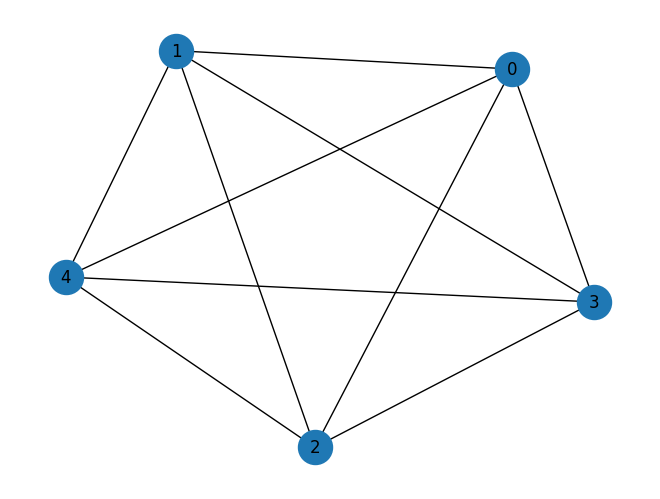

In [141]:
draw_graph(qaoa)

In [142]:
qaoa.edge_list

[(0, 1, 1.1499695766322697),
 (0, 2, 0.26429524488605927),
 (0, 3, 0.2409379279055382),
 (0, 4, 1.0628502221138603),
 (1, 2, 0.037969612064027825),
 (1, 3, 0.00488149959036057),
 (1, 4, 0.26757388418653694),
 (2, 3, 0.20314724654592864),
 (2, 4, 0.1636531948773697),
 (3, 4, 0.19204216845647434)]

In [143]:
# preparation utils

def build_max_cut_paulis(process: QAOAProcess) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    graph = process.graph
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list